In [1]:
# %% [markdown]
# # Measure performance
# This notebook loads a file with precomputed measures (*qmeans*, *qbas* & *qinv*) for a set of rankings for a given instance of the dataset and measures the performance of the different alternative measures
# 
# ## 1. Load libraries, model and data

# %%

# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt
import pickle

#MODEL_NAME = 'resnet50'
#REFERENCE_MODEL_NAME = MODEL_NAME#'resnet50w'

referenced_generation_modes = ['_genetic', '_captum']

OUTPUT_FILE = os.path.join(PROJ_DIR, 'results', 'results-per-file.pkl')
results = []

if os.path.isfile(OUTPUT_FILE):
    with open(OUTPUT_FILE, 'rb') as fOut:
        results = pickle.load(fOut)
else:
    for FILENAME in os.listdir(os.path.join(PROJ_DIR,'results')):
        if FILENAME.endswith(f'_measures.npz') and all([generation not in FILENAME for generation in referenced_generation_modes]):
            print(FILENAME)
    
            results_filename = {'file': FILENAME}
    
            # Load data
            data = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', FILENAME))
            
            qmeans = data['qmeans']
            #qmeans_basX = [data['qmean_bas']] # We don't look at qmean_bas, it will be recomputed later with the appropriate reference
            qmeans_basX = []
            qmeans_inv = data['qmean_invs']
    
            data_reference = data
            qmeans_reference = qmeans
            
            # Compute qmeans_bas[2-10]
            def compute_qbas(measure, num_samples, reference:np.ndarray):
                random_indices = np.random.randint(0, measure.shape[0], (measure.shape[0], num_samples))
                random_qmeans = reference[random_indices]
                mean = np.mean(random_qmeans, axis=1)
    
                # First way to deal with std==0; add some epsilon
                #std = np.std(random_qmeans, axis=1) + 1e-10
    
                # Second way to deal with std==0; ignore std (divide by 1)
                std = np.std(random_qmeans, axis=1)
                std[std==0] = 1
    
                # Always ignore std
                std=1
                return (measure - mean) / std
    
            for i in range(1,11):
                # If data is genetic, compute qbas with random data from other file
                qmeans_basX.append(compute_qbas(qmeans, i, qmeans_reference))
    
            # Compute z-score
            qmean_mean = np.mean(qmeans)
            qmean_std = np.std(qmeans)

            results_filename['activation'] = data['output_curves'][0][-1]
            results_filename['qmean_mean'] = qmean_mean
            results_filename['qmean_std'] = qmean_std
            
            z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()
            
            # Stratify z-index to be able to compare performance on different parts of the spectrum
            indices = np.arange(z_scores.shape[0])
            z_scores_numbered = np.vstack((z_scores, indices))
            level_indices = []
            boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
            for i in range(1,len(boundaries)+1):
                bottom_limit = boundaries[i-1]
                top_limit = float('inf')
                if i < len(boundaries):
                    top_limit = boundaries[i]
                level_indices.append((z_scores_numbered[:,np.logical_and(bottom_limit<=z_scores, z_scores<top_limit)][1,:].astype(int),(bottom_limit, top_limit)))
            
            def measure_correct_orderings(truths, estimators):
                '''
                Creates len(truth) x,y pairs and computes the fraction of them for which (truths[x]<truths[y] and estimators[x]<estimators[y]) or (truths[x]>truths[y] and estimators[x]>estimators[y])
                Inputs:
                    - Truths & estimators contain num_elems floats
                Output:
                    - Float representing the fraction of correctly ordered pairings
                '''
                xs = np.random.permutation(truths.size)
                ys = np.random.permutation(truths.size)
                truthX_lt_Y = truths[xs] < truths[ys]
                estimatorX_lt_Y = estimators[xs] < estimators[ys]
                hits = truthX_lt_Y==estimatorX_lt_Y
                return hits.sum()/truths.size
            
            correct_pairings_basX = []
            for i in range(len(qmeans_basX)):
                correct_pairings_basX.append(measure_correct_orderings(qmeans, qmeans_basX[i]))
    
            correct_pairings_inv = measure_correct_orderings(qmeans, qmeans_inv)
            results_filename['correct_pairings_effect'] = correct_pairings_inv - correct_pairings_basX[0]
    
            from scipy.stats import spearmanr
            spearman_basX = []
            for i in range(len(qmeans_basX)):
                spearman_basX.append(spearmanr(qmeans, qmeans_basX[i])[0])
            spearman_inv = spearmanr(qmeans, qmeans_inv)[0]
            results_filename['spearman_effect'] = spearman_inv - spearman_basX[0]
    
            # %%
            from sklearn import metrics
    
            def measure_detection(target_indices, estimator):
                if (len(target_indices)==0) or (len(target_indices) == estimator.shape[0]):
                    return float('nan')
                target = np.zeros_like(estimator, dtype=int)
                target[target_indices] = 1
                return metrics.roc_auc_score(target, estimator)
    
            aucs_inv = []
            aucs_basX = [[] for i in qmeans_basX]
    
            for indices, (bottom_limit, upper_limit) in level_indices:
                aucs_inv.append(measure_detection(indices, qmeans_inv))
                for i in range(len(qmeans_basX)):
                    aucs_basX[i].append(measure_detection(indices, qmeans_basX[i]))
    
            results_filename['auc_exceptional_effect'] = list(map(lambda x: x[0]-x[1], zip(aucs_inv, aucs_basX[0])))
    
            spearman_exceptional_inv = []
            spearman_exceptional_basX = [[] for i in qmeans_basX]
    
            for indices, (bottom_limit, upper_limit) in level_indices:
                spearman_exceptional_inv.append(spearmanr(qmeans[indices], qmeans_inv[indices])[0])
                for i in range(len(qmeans_basX)):
                    spearman_exceptional_basX[i].append(spearmanr(qmeans[indices], qmeans_basX[i][indices])[0])
    
            results_filename['spearman_exceptional_effect'] = list(map(lambda x: x[0]-x[1], zip(spearman_exceptional_inv, spearman_exceptional_basX[0])))
            results.append(results_filename)
    with open(OUTPUT_FILE, 'wb') as fOut:
        pickle.dump(results, fOut)

In [6]:
per_dataset_and_model = {}
for r in results:
    filename = r['file'].replace('-ood','_ood').replace('-undertrained', '_undertrained').replace('-untrained', '_untrained')
    parts = filename.split('_')
    dataset = parts[0]
    model = parts[-2]
    if len(parts) == 3:
        model = ''
    #print(f'{dataset:25s}\t{model:16s}\t({filename})')
    if (dataset + '|' + model) not in per_dataset_and_model:
        per_dataset_and_model[dataset + '|' + model] = []
    per_dataset_and_model[dataset + '|' + model].append([r['spearman_effect'], r['correct_pairings_effect'], r['qmean_std'], r['activation']])

0.0403	0.0464	cifar|resnet50
0.0417	0.0244	cifar|resnet50
0.0809	0.1286	cifar|resnet50
0.0539	0.0728	cifar|resnet50
0.1139	0.0900	20newsgroups-truncated|
0.1007	0.1047	20newsgroups-truncated|
0.1587	0.1527	20newsgroups-truncated|
0.0867	0.0988	20newsgroups-truncated|
0.1207	0.1025	20newsgroups-truncated|
0.1026	0.0970	20newsgroups-truncated|
0.1176	0.0981	20newsgroups-truncated|
0.1404	0.1092	20newsgroups-truncated|
0.0333	0.0573	20newsgroups-truncated|
0.0291	0.0401	20newsgroups-truncated|
0.1126	0.1297	glass|
0.2671	0.2492	glass|
0.2130	0.1218	avila|ood-zeros
0.0708	0.0367	mnist|softmax
0.1515	0.0554	mnist|softmax
0.0669	0.0342	mnist|softmax
0.0627	0.0302	mnist|softmax
0.2517	0.0690	mnist|softmax
0.0976	0.0334	mnist|softmax
0.1028	0.0598	mnist|softmax
0.1293	0.0554	mnist|softmax
0.2285	0.0973	mnist|softmax
0.0982	0.0563	mnist|softmax
-0.0009	0.0292	imagenet|resnet18
0.0102	0.0081	imagenet|resnet18
0.0178	0.0007	imagenet|resnet18
0.0160	0.0507	imagenet|resnet18
0.0289	0.0194	imagenet|

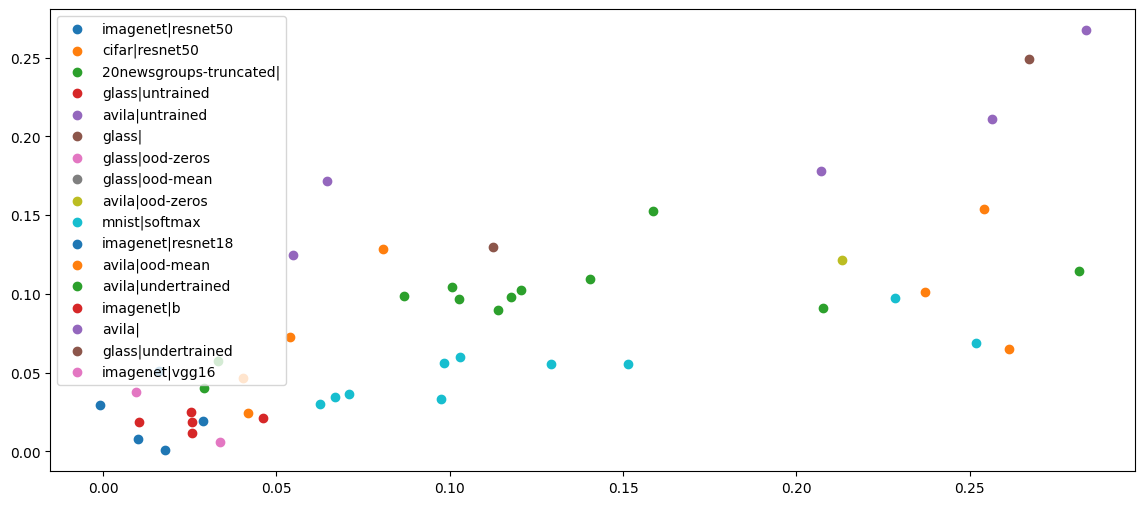

Spearman correlation 0.7563


In [11]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
x = []
y = []
plt.figure(figsize=(14,6))
for k in per_dataset_and_model:
    filtered = [x for x in per_dataset_and_model[k] if x[-1] > 0.8]
    x_k = list(map(lambda x: x[0], filtered))
    y_k = list(map(lambda x: x[-2], filtered))
    x += x_k
    y += y_k
    plt.scatter(x_k, y_k, label=k)
    for x_i, y_i in zip(x_k,y_k):
        print(f'{x_i:.4f}\t{y_i:.4f}\t{k}')
plt.legend()
plt.show()
print(f'Spearman correlation {spearmanr(x, y)[0]:.4f}')


In [13]:
print('Dataset & Model & Correct pairings & Spearman corr.\\\\\n\\hline')
for k in sorted(per_dataset_and_model):
    v = np.mean(per_dataset_and_model[k], axis=0)
    print(f'{k.split("|")[0]} & {k.split("|")[1]} & {v[2]:.4f} & {v[0]:.4f}\\\\')

Dataset & Model & Correct pairings & Spearman corr.\\
\hline
20newsgroups-truncated &  & 0.0950 & 0.1004\\
avila &  & 0.1906 & 0.1733\\
avila & ood-mean & 0.0799 & 0.2442\\
avila & ood-zeros & 0.0850 & 0.2131\\
avila & undertrained & 0.1046 & 0.2570\\
avila & untrained & 0.0010 & 0.2983\\
cifar & resnet50 & 0.0579 & 0.0435\\
glass &  & 0.1976 & 0.2039\\
glass & ood-mean & 0.0696 & 0.2619\\
glass & ood-zeros & 0.0519 & 0.2305\\
glass & undertrained & 0.1678 & 0.1847\\
glass & untrained & 0.0071 & 0.1634\\
imagenet & b & 0.0189 & 0.0266\\
imagenet & resnet18 & 0.0216 & 0.0144\\
imagenet & resnet50 & 0.0191 & 0.0156\\
imagenet & vgg16 & 0.0106 & 0.0103\\
mnist & softmax & 0.0528 & 0.1260\\
